In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

import seaborn as sns
%matplotlib inline

In [7]:
final = pd.read_csv("final.csv", 
                             names = ['case' ,'platform', 'customer_id', 'timeStamp',
                                      'matched_payment_complete', 'label', 'name', 'email', 'gender', 'age',
                                      'home_type', 'square_footage', 'number_of_bedrooms', 'number_of_floors',
                                      'household', 'platform_y', 'street', 'suburb'])
final['times_denid']=final.groupby('customer_id')['label'].cumsum()


#  Considering the new customers
final_2 = final.copy()
del final_2['case']
del final_2['times_denid']
del final_2['timeStamp']
del final_2['customer_id']
del final_2['street']
del final_2['email']
del final_2['name']
del final_2['platform_y']

del final_2['household'] # expecting to get more information outta here later!!!!
final_2.drop_duplicates(inplace=True)
X_ = final_2.drop("label", axis =1 )
Y_ = final_2.label
X_.gender = X_.gender.map({"male":1,"female":0})
le = preprocessing.LabelEncoder()
le.fit(X_.suburb.unique().tolist()) # taking all the suburbs 
X_.suburb = le.transform(X_.suburb)
le_plat = preprocessing.LabelEncoder()
le_plat.fit(X_.platform.unique().tolist()) 
X_.platform = le_plat.transform(X_.platform)

mid = int(X_.shape[0]*0.8)
X_train_ = X_[:mid]
Y_train_ = Y_[:mid]

X_test_ = X_[mid:]
Y_test_ = Y_[mid:]

In [8]:
# search for the best number of trees within a random forest
param_test1 = {
    'n_estimators':range(1,11)
}

clf = RandomForestClassifier(random_state=100)
grid_1 = GridSearchCV(clf, param_test1, cv=5, scoring='roc_auc')
grid_1.fit(X_train_,Y_train_)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=100, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': range(1, 11)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

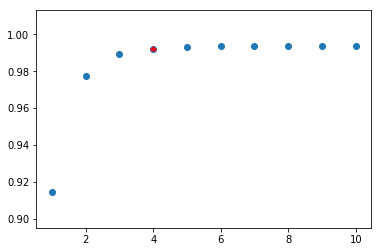

<Figure size 432x288 with 0 Axes>

In [9]:
x = range(1,11)
y = grid_1.cv_results_['mean_test_score']
# plt.plot(x,y)
plt.scatter(x,y)
plt.plot(x[4-1], y[4-1], 'r*')

fig = plt.gcf()
plt.show()
plt.draw()
fig.savefig('gridSearch1.png', dpi=100)

The search result indicates that growing 9 decision trees in one RF is optimal on this dataset
Then we conduct a grid search for the parameter combination max_depth and max_features. 

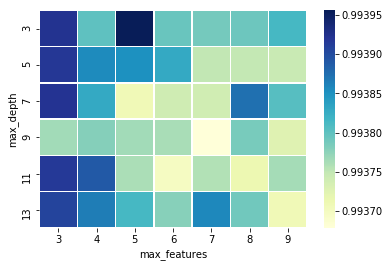

<Figure size 432x288 with 0 Axes>

In [12]:
param_test2 = {'max_depth':range(3,14,2), 
               'max_features':range(3,10)
              }
clf = RandomForestClassifier(random_state=100, n_estimators = 4)
grid_2 = GridSearchCV(clf, param_test2, cv=5, scoring='roc_auc',return_train_score=False)
grid_2.fit(X_train_,Y_train_)

Index = list(range(3,14,2))
Cols = list(range(3,10))
df = pd.DataFrame(grid_2.cv_results_["mean_test_score"].reshape((6,7)), index=Index, columns=Cols)
sns.heatmap(df,linewidths=.5,cmap="YlGnBu")
plt.xlabel('max_features')
plt.ylabel('max_depth')

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('gridSearch2.png', dpi=100)

In [13]:
# taking the optimal parameter combinations, train a model and examine results in test set
clf = RandomForestClassifier(random_state=100, n_estimators = 4,max_depth=3,max_features=5)

clf.fit(X_train_, Y_train_)

pred_label = pd.Series(clf.predict(X_test_))
y_test_ = pd.Series(Y_test_.tolist())

# True Negative rate on test:  TN / N
TN = ((y_test_ == pred_label)&(y_test_==0) ).sum()
TP = ((y_test_ == pred_label)&(y_test_==1) ).sum()

TNR = TN / (len(Y_test_)- Y_test_.sum())
TPR = TP/ Y_test_.sum()

FP = ((y_test_ != pred_label)&(y_test_==0) ).sum()
print("False Positives: {:.5f} normal people misclassified as frauds".format(FP))

FN = ((y_test_ != pred_label)&(y_test_==1) ).sum()
print("False Negatives: {:.5f} normal people misclassified as frauds".format(FN))

print("True Negative rate on test: {:.6f}".format(TNR))
# print("True Positives: {:.5f}".format(TP))
print("True Positive rate on test: {:.6f}".format(TPR))

False Positives: 346.00000 normal people misclassified as frauds
False Negatives: 0.00000 normal people misclassified as frauds
True Negative rate on test: 0.989074
True Positive rate on test: 1.000000


In [14]:
clf.feature_importances_

array([5.73674529e-03, 9.93893984e-01, 2.30047569e-05, 0.00000000e+00,
       8.17899883e-05, 1.21588795e-04, 4.48176310e-06, 0.00000000e+00,
       1.38405725e-04])

In [15]:
X_train_.columns

Index(['platform', 'matched_payment_complete', 'gender', 'age', 'home_type',
       'square_footage', 'number_of_bedrooms', 'number_of_floors', 'suburb'],
      dtype='object')